In [1]:
# Import
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt



from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from scipy.stats import zscore
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Input


Using TensorFlow backend.


In [2]:
# Import data
data = pd.read_csv('prices.csv', parse_dates=['Date'], 
                   low_memory=False)

In [3]:
data.shape

(1744, 19)

In [4]:
data = data[::-1]

In [5]:
data.head()

,Date,BOLSAA_Price,Bovespa_Brazil_50_Price,CAD_USD_Price,Canada_10Y_BY_Price,Canada_30Y_BY_Price,EUR_USD_Price,Euro_Stoxx_50_Price,JPY_USD_Price,Nikkei_225_Price,Shanghai_Shenzhen_CSI_300_Price,SnP_TSX_Composite_Price,SnP_500_Price,US_10Y_BY_Price,US_30Y_BY.csv_Price,Holiday,weekend,month,quarter
1743,2011-08-15,20.60,7739.02,1.0200,2.502,3.138,1.4446,2324.48,0.0130,9086.41,2917.88,12683.61,1204.49,2.308,3.773,False,False,Aug,Q3
1742,2011-08-16,20.78,7703.14,1.0180,2.452,3.113,1.4409,2323.67,0.0130,9107.43,2897.58,12530.71,1192.76,2.225,3.672,False,False,Aug,Q3
1741,2011-08-17,20.86,7808.20,1.0200,2.396,3.052,1.4425,2331.12,0.0130,9057.26,2886.01,12579.61,1193.89,2.167,3.565,False,False,Aug,Q3
1740,2011-08-18,20.11,7538.04,1.0099,2.300,2.958,1.4331,2206.61,0.0130,8943.76,2834.25,12186.71,1140.65,2.068,3.424,False,False,Aug,Q3
1739,2011-08-19,19.60,7414.85,1.0101,2.301,2.958,1.4398,2159.07,0.0131,8719.24,2807.66,12007.47,1123.53,2.067,3.397,False,False,Aug,Q3


In [6]:
data.dtypes

Date                               datetime64[ns]
BOLSAA_Price                              float64
Bovespa_Brazil_50_Price                   float64
CAD_USD_Price                             float64
Canada_10Y_BY_Price                       float64
Canada_30Y_BY_Price                       float64
EUR_USD_Price                             float64
Euro_Stoxx_50_Price                       float64
JPY_USD_Price                             float64
Nikkei_225_Price                          float64
Shanghai_Shenzhen_CSI_300_Price           float64
SnP_TSX_Composite_Price                   float64
SnP_500_Price                             float64
US_10Y_BY_Price                           float64
US_30Y_BY.csv_Price                       float64
Holiday                                      bool
weekend                                      bool
month                                      object
quarter                                    object
dtype: object

In [7]:
sum(data.isnull().sum() >0)

0

In [8]:
# Drop date variable
data.drop(['Date'], axis=1, inplace=True)

In [9]:
data['month'] = data.month.astype('category')

In [10]:
data.month = data.month.cat.set_categories(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

In [11]:
data.month.cat.categories

Index(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec'],
      dtype='object')

In [12]:
data.month = data.month.cat.codes + 1

In [13]:
data['quarter'] = data.quarter.astype('category')

In [14]:
data.quarter = data.quarter.cat.set_categories(['Q1', 'Q2', 'Q3', 'Q4'])

In [15]:
data.quarter.cat.categories

Index(['Q1', 'Q2', 'Q3', 'Q4'], dtype='object')

In [16]:
data.quarter = data.quarter.cat.codes+1

In [17]:
corr = data.corr()
corr.style.background_gradient()

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


,BOLSAA_Price,Bovespa_Brazil_50_Price,CAD_USD_Price,Canada_10Y_BY_Price,Canada_30Y_BY_Price,EUR_USD_Price,Euro_Stoxx_50_Price,JPY_USD_Price,Nikkei_225_Price,Shanghai_Shenzhen_CSI_300_Price,SnP_TSX_Composite_Price,SnP_500_Price,US_10Y_BY_Price,US_30Y_BY.csv_Price,Holiday,weekend,month,quarter
BOLSAA_Price,1,0.615935,-0.183222,0.071721,-0.111264,-0.110032,0.395107,-0.320535,0.449838,0.224818,0.40587,0.522407,0.246861,0.0146076,nan,nan,-0.0404375,-0.0240294
Bovespa_Brazil_50_Price,0.615935,1,-0.354141,0.135562,-0.154093,-0.207261,0.527672,-0.259365,0.590072,0.519419,0.694336,0.734284,0.391439,-0.101124,nan,nan,-0.076232,-0.0694674
CAD_USD_Price,-0.183222,-0.354141,1,0.581043,0.657485,0.867023,-0.752985,0.81581,-0.848702,-0.74435,-0.685494,-0.824704,-0.103098,0.457909,nan,nan,0.0747979,0.078873
Canada_10Y_BY_Price,0.071721,0.135562,0.581043,1,0.940279,0.784452,-0.147372,0.286548,-0.208787,-0.408138,-0.103749,-0.200477,0.718225,0.874167,nan,nan,0.0518891,0.0516821
Canada_30Y_BY_Price,-0.111264,-0.154093,0.657485,0.940279,1,0.812395,-0.27494,0.33567,-0.367976,-0.556652,-0.277531,-0.407948,0.618889,0.934979,nan,nan,0.0711454,0.0680488
EUR_USD_Price,-0.110032,-0.207261,0.867023,0.784452,0.812395,1,-0.559354,0.635249,-0.643849,-0.734252,-0.468568,-0.606032,0.234511,0.657242,nan,nan,0.0535129,0.0549898
Euro_Stoxx_50_Price,0.395107,0.527672,-0.752985,-0.147372,-0.27494,-0.559354,1,-0.885819,0.939904,0.703642,0.885546,0.893691,0.46716,-0.0917028,nan,nan,-0.0866118,-0.0852204
JPY_USD_Price,-0.320535,-0.259365,0.81581,0.286548,0.33567,0.635249,-0.885819,1,-0.906853,-0.623011,-0.731074,-0.803874,-0.36553,0.122997,nan,nan,0.0783752,0.0815359
Nikkei_225_Price,0.449838,0.590072,-0.848702,-0.208787,-0.367976,-0.643849,0.939904,-0.906853,1,0.784699,0.857624,0.955391,0.438673,-0.172472,nan,nan,-0.0640318,-0.0641631
Shanghai_Shenzhen_CSI_300_Price,0.224818,0.519419,-0.74435,-0.408138,-0.556652,-0.734252,0.703642,-0.623011,0.784699,1,0.622558,0.726689,0.0690482,-0.443813,nan,nan,-0.0671319,-0.0713967


In [18]:
train_index = round(len(data)*0.8)

In [19]:
# Scale data
def normalize(series):
    return (series - np.mean(series))/(max(series) - min(series))

In [20]:
data_norm = pd.concat([data.drop(['Holiday', 'weekend', 'month', 'quarter'], axis=1).apply(normalize), 
data.filter(items = ('Holiday', 'weekend', 'month', 'quarter'), axis=1)], axis=1)

In [21]:
data_norm.head()

,BOLSAA_Price,Bovespa_Brazil_50_Price,CAD_USD_Price,Canada_10Y_BY_Price,Canada_30Y_BY_Price,EUR_USD_Price,Euro_Stoxx_50_Price,JPY_USD_Price,Nikkei_225_Price,Shanghai_Shenzhen_CSI_300_Price,SnP_TSX_Composite_Price,SnP_500_Price,US_10Y_BY_Price,US_30Y_BY.csv_Price,Holiday,weekend,month,quarter
1743,-0.402050,-0.199446,0.443088,0.338416,0.407178,0.535464,-0.384621,0.592551,-0.416693,-0.039119,-0.233589,-0.410328,0.066042,0.404758,False,False,8,3
1742,-0.393055,-0.203757,0.437310,0.311606,0.392777,0.526490,-0.385063,0.592551,-0.415376,-0.045333,-0.262796,-0.416941,0.018802,0.350632,False,False,8,3
1741,-0.389057,-0.191136,0.443088,0.281579,0.357639,0.530371,-0.381000,0.592551,-0.418519,-0.048875,-0.253455,-0.416304,-0.014209,0.293290,False,False,8,3
1740,-0.426538,-0.223590,0.413906,0.230105,0.303491,0.507572,-0.448899,0.592551,-0.425629,-0.064719,-0.328507,-0.446321,-0.070555,0.217727,False,False,8,3
1739,-0.452025,-0.238390,0.414484,0.230641,0.303491,0.523822,-0.474823,0.611782,-0.439693,-0.072858,-0.362745,-0.455974,-0.071124,0.203258,False,False,8,3


In [22]:
train_data = {}
test_data = {}
train_dep = {}
test_dep = {}

In [153]:
for col_names in data_norm.columns[:14]:
    print(col_names, "\n")
    train_data[col_names] = data_norm.iloc[:train_index,:].drop(col_names, axis=1)
    test_data[col_names] = data_norm.iloc[train_index:,:].drop(col_names, axis=1)

    train_dep[col_names] = data_norm.iloc[:train_index][col_names]
    test_dep[col_names] = data_norm.iloc[train_index:][col_names]

BOLSAA_Price 

Bovespa_Brazil_50_Price 

CAD_USD_Price 

Canada_10Y_BY_Price 

Canada_30Y_BY_Price 

EUR_USD_Price 

Euro_Stoxx_50_Price 

JPY_USD_Price 

Nikkei_225_Price 

Shanghai_Shenzhen_CSI_300_Price 

SnP_TSX_Composite_Price 

SnP_500_Price 

US_10Y_BY_Price 

US_30Y_BY.csv_Price 



In [154]:
train_x = train_data['Canada_10Y_BY_Price']
test_x = test_data['Canada_10Y_BY_Price']
train_y = train_dep['Canada_10Y_BY_Price']
test_y = test_dep['Canada_10Y_BY_Price']

In [155]:
n_stocks = train_x.shape[1]

In [156]:
train_x.shape

(1395, 17)

In [159]:
model = Sequential()
model.add(Dense(100, input_dim=n_stocks, activation='linear'))
model.add(Dense(50, activation='linear'))
model.add(Dense(25, activation='linear'))
model.add(Dense(10, activation='linear'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
             metrics=['mean_absolute_percentage_error'])
monitor = EarlyStopping(monitor='mean_absolute_percentage_error', min_delta=.00001, 
                        patience=5, verbose=1, mode='auto')
model.fit(train_x,train_y, verbose = 0, callbacks=[monitor], epochs=30)

model.evaluate(test_x, test_y, sample_weight=None)

349/349 [==============================] - 0s 475us/step


[0.005155916683333138, 693.918082983241]

In [160]:
# Predict and measure RMSE
pred = model.predict(test_x)
score = np.sqrt(metrics.mean_squared_error(pred,test_y))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.07180471172698584


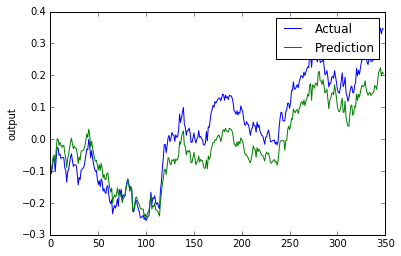

In [161]:
plt.plot(range(0,349),test_y,label='Actual')
plt.plot(range(0,349), pred,label='Prediction')
plt.ylabel('output')
plt.legend()
plt.show()

In [175]:
def dropval(series, position=0, days=1, percent=0):
    result = np.array([])
    progress = (percent/100)/days
    print("Step of progress {}".format(progress))
    if position!=0:
        result = np.append(result, series[:position])
    if(progress==0):
        print("No drop value mentioned")
    else:
        for i in range(days):
            loc = (len(series) - (position+i+1))
            print("loc is {}".format(loc))
            print("Series original val {}".format(series[loc]))
            result = np.append(result, (series[loc] - abs(series[loc] * (i+1) * progress)))
        result = np.append(result, series[(position+days):])
    return result

In [176]:
org_price = test_x['JPY_USD_Price'].copy()
new_price = org_price.copy()

print(new_price[10:15])
new_price = dropval(new_price,position=10,days=5,percent=20)
print(new_price[10:15])

338   -0.215141
337   -0.195910
336   -0.215141
335   -0.195910
334   -0.195910
Name: JPY_USD_Price, dtype: float64
Step of progress 0.04
loc is 338
Series original val -0.21514092272406518
loc is 337
Series original val -0.19591015349329607
loc is 336
Series original val -0.21514092272406518
loc is 335
Series original val -0.19591015349329607
loc is 334
Series original val -0.19591015349329607
[-0.22374656 -0.21158297 -0.24095783 -0.22725578 -0.23509218]


In [177]:
#org_price = test_x['JPY_USD_Price']
test_x['JPY_USD_Price'] = new_price

pred2 = model.predict(test_x)
score = np.sqrt(metrics.mean_squared_error(pred2,test_y))
test_x['JPY_USD_Price'] = org_price

print("Score (RMSE): {}".format(score))


Score (RMSE): 0.07179127973975488


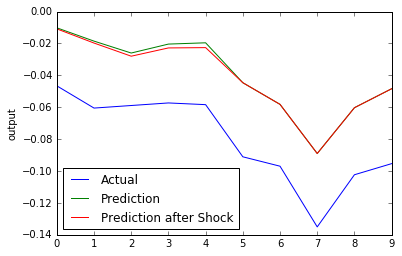

In [180]:
plt.plot(range(0,10),test_y[10:20],label='Actual')
plt.plot(range(0,10),pred[10:20],label='Prediction')
plt.plot(range(0,10), pred2[10:20],label='Prediction after Shock')
ax = plt.subplot(111)
plt.ylabel('output')
ax.legend(loc='lower left')
plt.show()

In [181]:
test_x['JPY_USD_Price'] = org_price

In [182]:
np.sqrt(metrics.mean_squared_error(pred2,pred))

0.00024439936

In [183]:
train_x = train_data['CAD_USD_Price']
test_x = test_data['CAD_USD_Price']
train_y = train_dep['CAD_USD_Price']
test_y = test_dep['CAD_USD_Price']

In [184]:
n_stocks = train_x.shape[1]

In [187]:
model1 = Sequential()
model1.add(Dense(100, input_dim=n_stocks, activation='linear'))
model1.add(Dense(50, activation='linear'))
model1.add(Dense(25, activation='linear'))
model1.add(Dense(10, activation='linear'))
model1.add(Dense(1, activation='linear'))
model1.compile(loss='mse', optimizer='adam',
             metrics=['mean_absolute_percentage_error'])
monitor = EarlyStopping(monitor='mean_absolute_percentage_error', min_delta=.00001, 
                        patience=5, verbose=1, mode='auto')
model1.fit(train_x,train_y, verbose = 0, epochs=30)

model1.evaluate(test_x, test_y, sample_weight=None)

349/349 [==============================] - 0s 482us/step


[0.0030295897974368493, 18.615865436870937]

In [188]:
# Predict and measure RMSE
pred = model1.predict(test_x)
score = np.sqrt(metrics.mean_squared_error(pred,test_y))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.055041708946002216


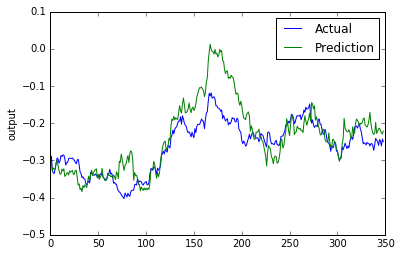

In [189]:
plt.plot(range(0,349),test_y,label='Actual')
plt.plot(range(0,349), pred,label='Prediction')
plt.ylabel('output')
plt.legend()
plt.show()

In [ ]:
#new_price = test_x['JPY_USD_Price'].apply(dropval)

In [190]:
#org_price = test_x['JPY_USD_Price']
test_x['JPY_USD_Price'] = new_price

pred2 = model1.predict(test_x)
score = np.sqrt(metrics.mean_squared_error(pred2,test_y))
test_x['JPY_USD_Price'] = org_price

print("Score (RMSE): {}".format(score))


Score (RMSE): 0.05500991333941457


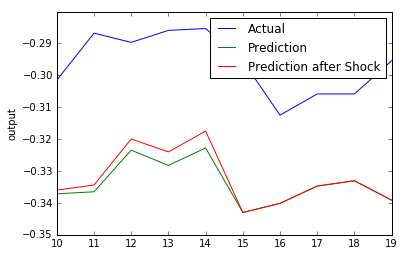

In [191]:
plt.plot(range(10,20),test_y[10:20],label='Actual')
plt.plot(range(10,20),pred[10:20],label='Prediction')
plt.plot(range(10,20), pred2[10:20],label='Prediction after Shock')
plt.ylabel('output')
plt.legend()
plt.show()

In [192]:
np.sqrt(metrics.mean_squared_error(pred2,pred))

0.00042828292

- Shock to small data in the series and find the prediction.